# COMP5318 Week 9: Clustering 1: K-means and GMM

Clustering involves partitioning the dataset into groups, called clusters. The goal is to split the dats in such a way so that the examples (data points) within each cluster are similar to each other, while the examples from different clusters are dissimilar. Clustering is an unsupervised learning task - the examples don't have class labels. 

This week we will cover two clustering algoritrhms: K-means and Gaussian Mixture Models (GMM) and hierarchical clustering, and next week we will cover hierarchical, density-based and grid-based clustering, and also clustering evaluation. 

# 1. Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
TOPIC_ID = "clustering1"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", TOPIC_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)



In [2]:
# More plot functions

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)    

from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)    
        
        
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))        

## 2. K-means 

K-Means is one of the most popular clustering algorithms; it works as follows:

- Initialize 𝑘 centroids randomly: 𝑘 distinct examples are chosen randomly from the dataset and the centroids are placed at their locations.
- Repeat until convergence (i.e. until the centroids stop moving):
    - Assign each example to the closest centroid
    - Update the centroids to be the mean of the examples that are assigned to them

Let's generate some blobs data:

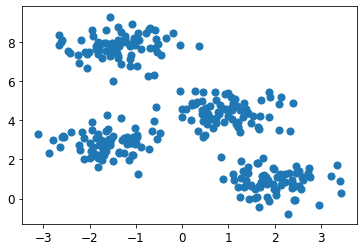

In [3]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

Looking at the data, there are 4 well-separated clusters. Now let's apply the K-means algorithm with k=4 to see if it can find the 4 clusters:

### Fit and Predict

In [4]:
from sklearn.cluster import KMeans

# select the parameter k for number of clusters
k=4
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Using <b>predict</b>, each example is assigned to one of the four clusters (0, 1, 2 or 3). We can look at the cluster label for each example and the cluster centroids, and we can visualize the result by plotting the data colored by the cluster label:

In [5]:
y_kmeans

array([1, 0, 2, 0, 1, 1, 3, 2, 0, 0, 3, 0, 2, 0, 1, 2, 2, 1, 3, 3, 1, 1,
       2, 3, 3, 2, 1, 2, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 3, 1, 2, 3, 2, 2,
       3, 3, 0, 3, 0, 1, 3, 1, 0, 1, 1, 3, 0, 3, 0, 1, 0, 2, 0, 3, 3, 3,
       0, 1, 0, 3, 2, 3, 0, 3, 3, 0, 3, 2, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2,
       0, 0, 2, 1, 0, 3, 3, 2, 1, 1, 2, 3, 0, 1, 0, 1, 2, 1, 1, 2, 0, 2,
       3, 3, 1, 0, 1, 2, 0, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 0, 3,
       3, 1, 0, 3, 3, 0, 2, 0, 0, 3, 2, 3, 2, 3, 0, 2, 0, 0, 0, 2, 0, 2,
       1, 3, 0, 3, 1, 2, 0, 2, 2, 1, 2, 3, 3, 2, 1, 2, 2, 0, 1, 2, 3, 0,
       1, 1, 2, 3, 1, 2, 3, 3, 2, 2, 2, 2, 1, 0, 2, 3, 2, 2, 3, 3, 3, 2,
       3, 0, 2, 3, 1, 3, 2, 0, 3, 0, 2, 0, 2, 3, 2, 2, 0, 3, 3, 1, 1, 2,
       0, 1, 1, 3, 1, 3, 2, 0, 0, 2, 2, 0, 2, 1, 3, 2, 1, 3, 0, 3, 1, 2,
       1, 0, 0, 0, 0, 3, 3, 0, 2, 3, 1, 2, 3, 3, 3, 1, 1, 0, 2, 2, 3, 1,
       0, 3, 2, 0, 2, 1, 1, 3, 3, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 1,
       0, 3, 0, 2, 1, 1, 0, 0, 0, 1, 1, 2, 0, 3])

In [6]:
kmeans.cluster_centers_

array([[-1.37324398,  7.75368871],
       [ 1.98258281,  0.86771314],
       [ 0.94973532,  4.41906906],
       [-1.58438467,  2.83081263]])

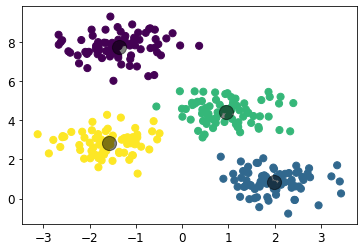

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


K-means has done a good job assigning the examples to the appropriate cluster!

We can also find the cluster of new examples - these examples will be assigned to the cluster of the closest centroid:

In [8]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([3, 1, 3, 3])

### Decision boundaries

Let's plot the decision boundaries. This gives us a _Voronoi diagram_ where each centroid is represented with an X:

Saving figure voronoi_plot


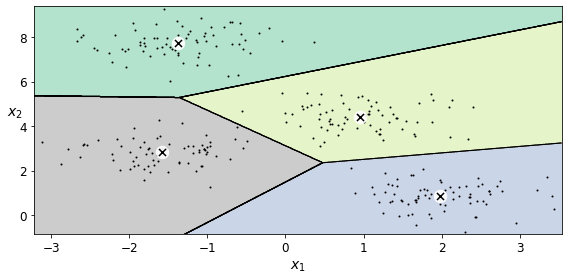

In [9]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

### K-means in action

The following example shows the K-means algorithm in action: the centroids are initialized randomly, then the examples are assigned to the closest centroid, then the centroids are updated, the examples are re-asiigned and so on for 3 iterations. As you can see, the centroids don't move much in the third iteration and the algorithm has reached a clustering that separates well the data points. 

In [10]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

Saving figure kmeans_algorithm_plot


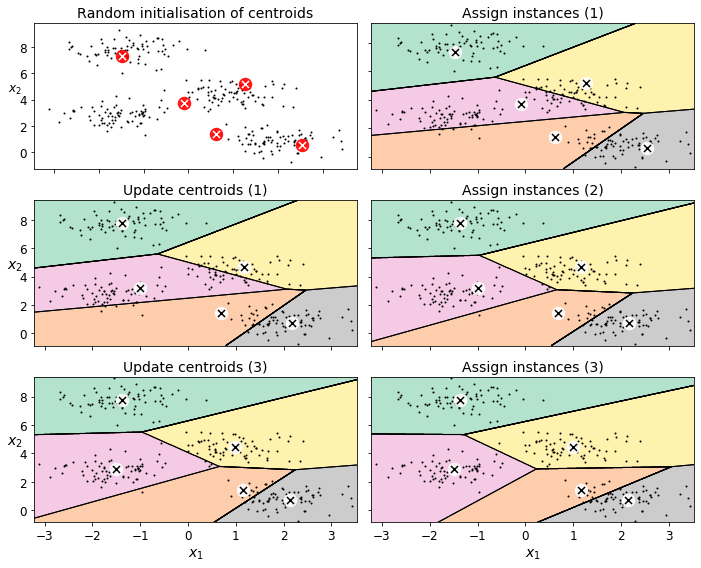

In [11]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=12, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Random initialisation of centroids", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Assign instances (1)", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)
plt.title("Update centroids (1)", fontsize=14)


plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)
plt.title("Assign instances (2)", fontsize=14)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)
plt.title("Update centroids (3)", fontsize=14)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)
plt.title("Assign instances (3)", fontsize=14)

save_fig("kmeans_algorithm_plot")
plt.show()

## 2. K-means - issues

### Initialization

K-means is sensitive to the centroid initialization. If we run it multiple times with different random initialization, it can converge to very different solutions. Let's use two different random seeds and visualise the decision boundaries and final centroids - they are different:

In [12]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


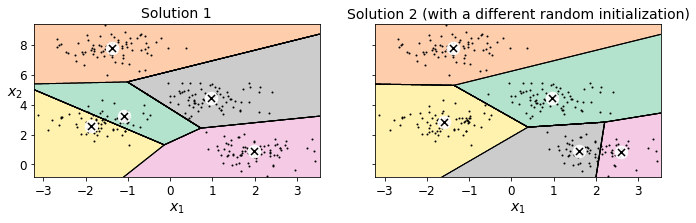

In [13]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random initialization)")

save_fig("kmeans_variability_plot")
plt.show()

### Questions:

1. How can we deal with this senitivity to initialization? Hint: Multiple runs? Can we use the  <b>n_init </b> hyperparameter? Write the code and visualise the decision boundary.
2. What methods did we study in the lecture?



### Answers:

1. We can train K-means multiple times with diferent random initialization and select the solution that minimizes the error, e.g. the sum of the squared distances between the instances and the closest centroid. The number of runs is specified by <b>n_init </b>; let's do 10 runs - see the code below. 
2. We can use other versions of K-means such as K-Means++ or bisecting K-means. To run K-Means++, set the <b> init </b> hyperparameter to <b> init='k-means++' </b>.


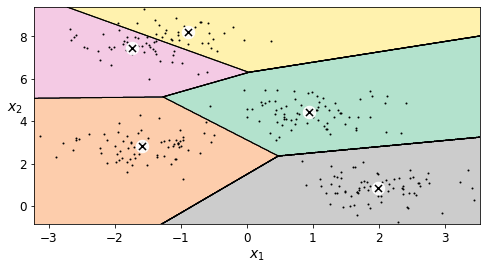

In [14]:
# 10 random initialiaztions, choose the best one
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

# plot the results
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### Number of clusters

K-means requires the number of clusters 𝑘 to be pre-specified. So far, we have set 𝑘 to 4 because it was obvious by looking at the data that there are 4 clusters. But in general, we don't know what the correct number of clusters is. K-means will always return clustreing solution, e.g. if we ask it to identify 6 clusters, it will find the best 6 clusters (as shown below) but this is not a good clustering as two of the natural clusters are split into two. Next week we will study methods for selecting the best number of clusters, such as the Elbow method and Silhouette coefficient.

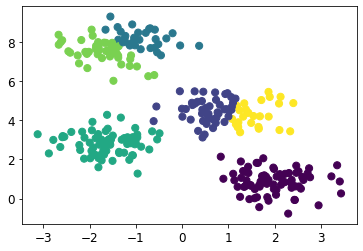

In [15]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Clusters with nonsperical shapes or complex shapes

Even if you know the right number of clusters for the given dataset, K-means might not always be able to find them. Each cluster is defined by its center, which means that each cluster has a convex shape. In addition, the boundary between clusters is exactly in the middle between the cluster centroids. As a result, K-means can only capture clusters with relatively simple shapes. The examples below show its inability to identify nonsperical clusters and clusters with complex shapes.

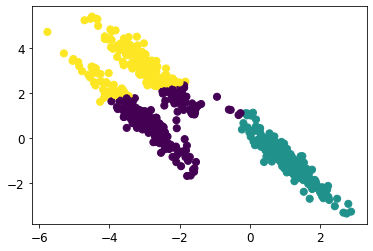

In [16]:
#Clusters with nonspherical shape

# generate some random cluster data
X1, y1 = make_blobs(random_state=170, n_samples=600)
rng = np.random.RandomState(74)

# transform the data to be stretched
transformation = rng.normal(size=(2, 2))
X1 = np.dot(X1, transformation)

# cluster the data into three clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X1)
labels = kmeans.predict(X1)

plt.scatter(X1[:, 0], X1[:, 1], c=labels, s=50, cmap='viridis');

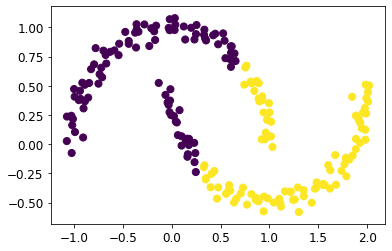

In [17]:
# clusters with complex shape
from sklearn.datasets import make_moons
X2, y2 = make_moons(200, noise=.05, random_state=0)

labels = KMeans(2, random_state=0).fit_predict(X2)

plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=50, cmap='viridis');

One way to think about K-means is that it places a circle (or a sphere/hypersphere in higher dimensions) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize the clusters using the plot_kmeans function:

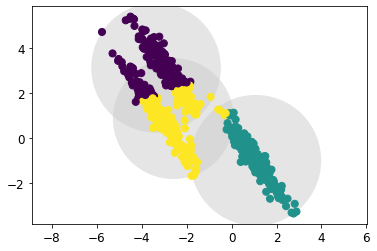

In [18]:
# Plot the clusters
plot_kmeans(kmeans, X1)

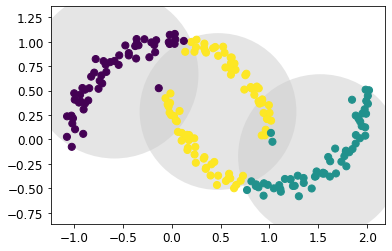

In [19]:
plot_kmeans(kmeans, X2)

Another disadvantage of K-means is that it doesn't consider the certaintly of the clustering assignment - it is more certain for the points closer to the cluster centroid and less certain for the points closer to the boundaries, but K-means doesn't use a probabilistic cluster assignment. 

# 4. Gaussian Mixture Model (GMM)

These two disadvantages of K-means — its lack of flexibility in cluster shape and lack of probabilistic cluster assignment, are addressed in the GMM clustering algorithm. It can be seen as a generalized version of K-means - it allows cluster boundaries to be ellipses rather than circles and measures the uncertainty in cluster assignment by considering the probability of each data point to belong to all clusters, rather than focusing on just the closest cluster.

GMM assumes that the instances are generates from a mixture of k Gaussian distributions whose parameters (mean values and covariance matrix) are unknown. Starting from an initial set of model parameters, it uses the Expectation Maximization algorithm to iteratively calculate the model parameters. In the E step, it calculats the probability of each instance to belong to each cluster. Then in the M step, it uses these probabilities to reculculate the model parameters. 

Let's apply GMM to a streched version of the blobs dataset and plot the result:

In [20]:
from sklearn.mixture import GaussianMixture as GMM
#gmm = GMM(n_components=4, random_state=42, max_iter=1, warm_start=True)
gmm = GMM(n_components=4, random_state=42)

# Generate stretched blobs data:
X_stretched = np.dot(X, rng.randn(2, 2))

# fit the GNN model
gmm.fit(X_stretched)

GaussianMixture(n_components=4, random_state=42)

We can loook at the parameters that the algorithm has estimated (mean values, covariances and weights of each cluster):

In [21]:
print('Cluster centers (means):\n',gmm.means_)
print('Cluster covariances:\n',gmm.covariances_)
print('Cluster weights:\n',gmm.weights_)

Cluster centers (means):
 [[ 6.38193228 10.60317015]
 [ 1.52079671  4.51185984]
 [ 2.28968749 -0.08915117]
 [ 4.90221153  5.01106158]]
Cluster covariances:
 [[[0.60999207 0.2857123 ]
  [0.2857123  0.70758172]]

 [[0.469843   0.23216315]
  [0.23216315 0.59097787]]

 [[0.46263817 0.25704027]
  [0.25704027 0.71111045]]

 [[0.49436611 0.24387942]
  [0.24387942 0.72442228]]]
Cluster weights:
 [0.2498826  0.24836039 0.24991271 0.2518443 ]


We can use the function <b> gmm_plot </b> to visualize the location and shapes of the GMM clusters by drawing elipses based on the GMM parameters we found:

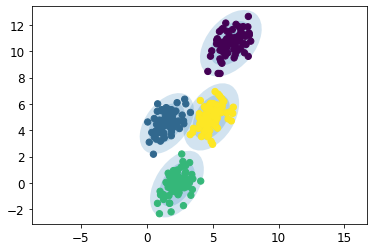

In [22]:
plot_gmm(gmm, X_stretched)

Now that we know the parameters of the clusters, we can find the cluster of new examples by using the method <b> predict </b> (hard clustering, which gives the most likily cluster) or <b> predict_prova </b> (soft clustering, which gives the membership probailities for each cluster):

In [23]:
gmm.predict(X)

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1,
       2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1], d

In [24]:
gmm.predict_proba(X)

array([[1.06765578e-22, 9.96279760e-01, 3.71693038e-03, 3.31006821e-06],
       [6.18172372e-10, 9.99999999e-01, 1.71453423e-29, 1.23145704e-16],
       [9.51317768e-14, 9.99999943e-01, 5.70208228e-14, 5.73718890e-08],
       ...,
       [8.61233868e-17, 9.99999999e-01, 6.78119023e-14, 6.38269066e-10],
       [2.51872722e-06, 9.99997481e-01, 1.03258492e-25, 1.73336972e-11],
       [1.17486271e-25, 1.00000000e+00, 1.83967253e-13, 8.93934145e-16]])

### Task:

Apply GMM to the moons data (which has complex shape) and visualise the clusters. Does it work well and why?


### Answer

It is better than K-means but not perfect. GMM is suitable for clusters with ellipsoidal shapes.



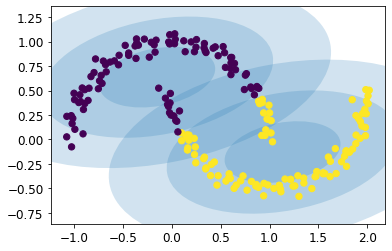

In [25]:
gmm2 = GMM(n_components=2, random_state=42)
plot_gmm(gmm2, X2)

# 5. K-means for color compression

One interesting application of clustering is for colour compression of images to reduce the number of colors (vector quantization). In most images, a large number of the colours will be unused, and many of the pixels in the image will have similar or even identical colours. 

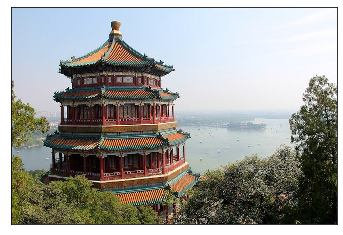

In [26]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)

The image is stored in a 3-dimensional array of size (height, width, RGB), containing the red, blue and green components of each pixel as integers from 0 to 255:

In [27]:
china.shape

(427, 640, 3)

We can view the pixels as a set of points in a 3-dimensional color space. We reshape the data to [n_samples x n_features] and rescale the colors so that they lie between 0 and 1:

In [28]:
data = china / 255.0
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10 000 pixels for efficiency:

In [29]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

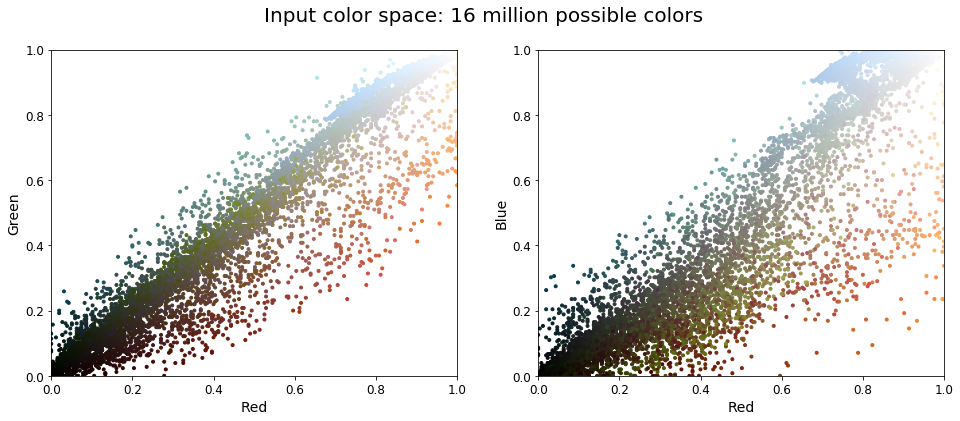

In [30]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, by using the K-means clustering algorithm to cluster the points. Because we are dealing with a very large dataset, we will use the mini batch K-means, which operates on subsets of the data to compute the result much more quickly than the standard K-means algorithm:

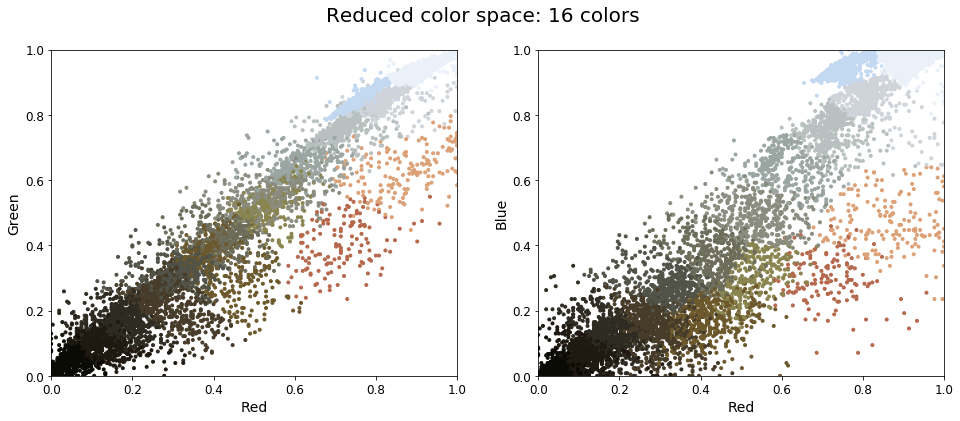

In [31]:
#import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center. Now we can plot the image using these colors:

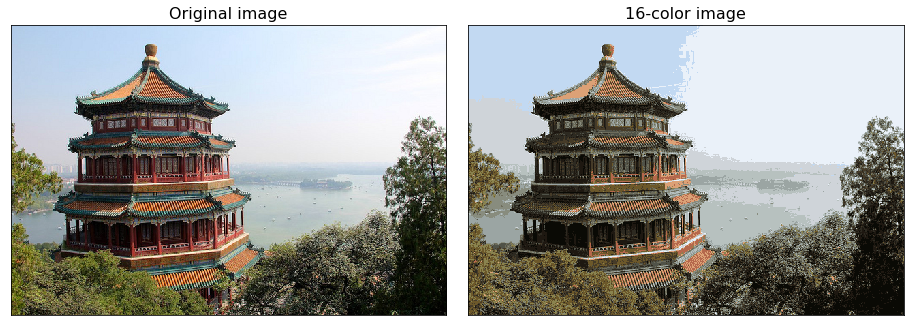

In [32]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color image', size=16);

The compressed image is pretty good! The compression factor is about 1 million - from 16 million colors to 16 colors. 

This is an interesting application of K-means but there are better ways to compress images.

### Task:
Load the flower.jpg image from the same colection, compress it to a small number of colors, e.g. 24, 6 and 3. Show the original and compressed images and compare them.

### Solution:   


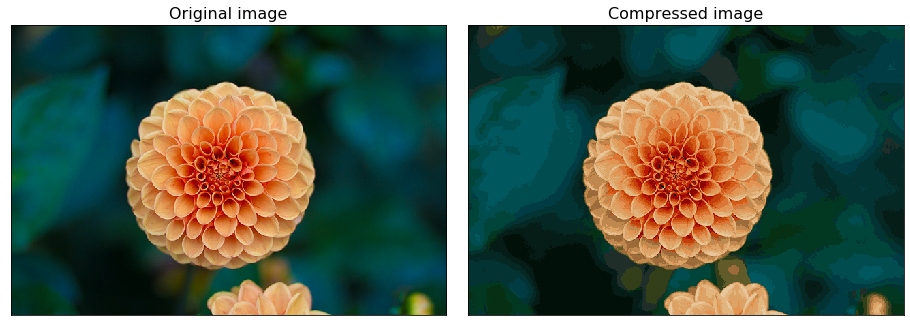

In [33]:
from sklearn.datasets import load_sample_image
flower = load_sample_image("flower.jpg")

# Reshape data
flower_data = flower / 255.0
flower_data = flower_data.reshape(427 * 640, 3)
flower_data.shape

# Cluster data
num_colors=24 # number of colors
kmeans = MiniBatchKMeans(num_colors)
kmeans.fit(flower_data)
new_colors = kmeans.cluster_centers_[kmeans.predict(flower_data)]

# Re-color and show images
flower_recolored = new_colors.reshape(flower.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(flower)
ax[0].set_title('Original image', size=16)
ax[1].imshow(flower_recolored)
ax[1].set_title('Compressed image', size=16);

## Summary

In [34]:
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
gmm = GMM(n_components=k)
gmm.fit(X)
gmm.predict_proba(X);

### Acknowledgements

This tutorial is based on:

Aurelien Geron (2019). Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly.

Jake VanderPlas (2016). Python Data Science Handbook, O'Reilly.